## SOEE3250/SOEE5675M/5116					

Inverse Theory

# Practical 8: Neighbourhood Algorithm
In this practical you will learn how to find the optimal solution in a two-parameter non-linear problem using the neighbourhood algorithm. 

## Inverse problem description

You are given 10 observations made at different times, and a mathematical model (with unknown parameters $x$ and $y$) that predicts the value of an observation made at time t:    
$$ g(t,x,y)  =1+ \frac{\sin⁡(x/4)+\sin(y/5)}{\sqrt{(x+t)^2+y^2}}$$

The objective function (here, also the likelihood) is given by
$$ \sigma = e^{- \sum_i(g(t_i,x,y)-d_i)^2}$$

The goal of this practical is to estimate $x$ and $y$ by finding the location in model space with the greatest value of $\sigma$. 

Data $d$ is collected for $t=1,2,3,\dots,10$.

The data and times are provided below.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from scipy.spatial import Voronoi, voronoi_plot_2d

In [2]:
t = np.arange(1,11)
d = np.array([0.822,   0.809,   0.791,   0.800,   0.796,   0.781,  0.765,  0.792,   0.792,   0.776])
print(t)
print(d)

[ 1  2  3  4  5  6  7  8  9 10]
[0.822 0.809 0.791 0.8   0.796 0.781 0.765 0.792 0.792 0.776]


Q1) Run the following code to generate 15 realisations of models $(x,y)$, where both $x$ and $y$ are between -100 and 100.
Use the voronoi function to plot the nearest neighbour (Voronoi) cell for each of the 15 random model combinations of x and y.

What do the orange circle represent?

Text(0, 0.5, 'Y')

<Figure size 432x288 with 0 Axes>

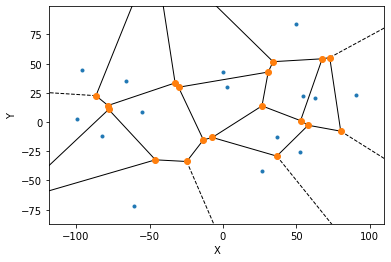

In [3]:
np.random.seed(seed=10)
X,Y = np.random.uniform(low = -100, high = 100, size=(2,15))
coords = np.array(list(zip(X, Y))) # combine the (x,y) cooordinates in the way that the Voronoi function expects.
plt.figure()
vor = Voronoi(coords)
fig = voronoi_plot_2d(vor)
plt.xlabel('X')
plt.ylabel('Y')

Q2) Complete the likelihood function

In [4]:
def likelihood(X,Y):
    '''Calculate the likelihood for specific values X and Y'''
    r = np.zeros(10)
    d = np.array([0.822,   0.809,   0.791 ,  0.800 ,  0.796 ,  0.781 , 0.765,  0.792 ,  0.792 ,  0.776])
    t = np.arange(1,11)
    for i in range(10):
        r[i]=d[i]-(1+(np.sin(X/4)+np.sin(Y/5)) / np.sqrt((X+t[i])**2+Y**2))
    return np.exp(-np.sum(r**2))


Q3) Calculate the likelihood for each of the 15 random models and store them in the vector sigma_m.
Copy and paste your plotting code from above, and use plt.scatter to add the 15 models to your Voronoi plot, with likelihood indicated by colour.

Which is the most likely model?

<Figure size 432x288 with 0 Axes>

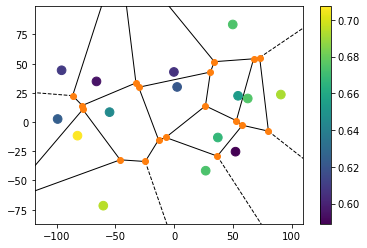

In [6]:
p=15

sigma_m = np.zeros(p)
for j in range(p):
    sigma_m[j]=likelihood(X[j],Y[j]) 
plt.figure()
fig = voronoi_plot_2d(vor)
plt.scatter(X,Y,s=75, c=sigma_m,alpha=1,zorder=3)
plt.colorbar()

Q4) Run the code cell below to define a key function. You do not need to understand how the function works.

In [7]:
def voronoi_intersect(m_rw,m_vor,m_all,dim,dim_lims):
    '''VORONOI_INTERSECT returns intersect values between the axis running through the
     current model along a specified dimension, and the Voronoi diagram
     
   M_RW   = random walk model (Mx1 vector)
   M_VOR  = model on which Voronoi cell is based (Mx1 vector)
   M_ALL  = all models that have been sampled (MxN vector)
   DIM    = specified dimension (a number between 1 and M)
   DIM_LIMS = lower and upper bounds for the specified dimension (1x2 vector) '''
    
    # Based on Matlab code written by Andy Hooper.
    
    n_all=m_all.shape[1]
    dk=m_vor-m_rw
    dk[dim] = 0
    dk2=np.sum(dk**2) # distance to axis of m_vor, squared
    dj=np.matlib.repmat(m_rw,1,n_all)-m_all
    dj[dim,:]=0
    dj2=np.sum(dj**2,axis=0)  # distance to axis of m_all, squared
    
    m_vor=np.matlib.repmat(m_vor[dim],1,n_all)
    m_all=m_all[dim,:]
    
    np.seterr(all = 'ignore')
    intersects=(m_vor+m_all+(dk2-dj2)/(m_vor-m_all))/2
    intersects = intersects[~np.isnan(intersects)]
    
    low= max(np.append(intersects[intersects<m_rw[dim]],dim_lims[0]))
    high=min(np.append(intersects[intersects>m_rw[dim]],dim_lims[1]))
    return low,high

## Neighbourhood algorithm

Here is the algorithm to generate $p$ new models in a cell defined by the vertex m_vor corresponding to the highest likelihood

- Order the likelihoods in decreasing order. Find the (X,Y) values corresponding to the largest likelihood
- initialise m_all to be the known (X,Y) positions
- initialise m_save, sigma_m_save to be empty vectors, at each iteration you will append to these vectors.
- define m_vor to be the vertex of highest likelihood
- do the following $p$ times:

    - define m_curr (the initial position of the new model, before the random walk) to be m_vor
    - use the function voronoi_intersect to find where a line drawn parallel with the x-axis intersects the Voronoi cell boundaries  (set m_curr and m_vor to the model with the highest likelihood, and use -100 and 100 as the limits)
    - update the $x$ value for m_curr using a random number between these 2 boundaries
    - use voronoi_intersect to find where a line drawn parallel with the y-axis through m_curr, intersects the Voronoi cell boundaries (use -100 and 100 as the limits);
    - update the $y$ value for m_curr using a random number between these 2 boundaries
    - calculate the likelihood
    - add the new model to m_save, and the sigma value to sigma_m_save


- At the end of the loop, m_save contains all the saved new models, with corresponding values in sigma_m_save

<Figure size 432x288 with 0 Axes>

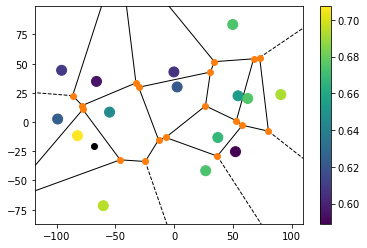

In [8]:
I = np.flip(np.argsort(sigma_m))

m_all = np.zeros((2,15))
m_save = np.empty((2,0), float)
sigma_m_save = np.empty((1,0), float)
m_all[0,:] = X
m_all[1,:] = Y

m_vor = np.zeros((2,1))


j=0
m_vor[0], m_vor[1] = X[I[0]], Y[I[0]]
m_curr = m_vor.copy()
low,high=voronoi_intersect(m_curr,m_vor,m_all,0,[-100, 100])
m_curr[0]=np.random.uniform(low = low, high = high, size=1)
low,high=voronoi_intersect(m_curr,m_vor,m_all,1,[-100, 100])
m_curr[1]=np.random.uniform(low = low, high = high, size=1)
m_save = np.append( m_save, m_curr, axis=1)
sigma_m_save = np.append(sigma_m_save, likelihood(m_curr[0], m_curr[1]))

# Make a plot
plt.figure()
fig = voronoi_plot_2d(vor)
plt.scatter(X,Y,s=100, c=sigma_m,alpha=1,zorder=3)  # These are the initial models
plt.colorbar()
plt.scatter(m_save[0,:],m_save[1,:],c='black');  # These are the new models

Q5) Where is the model in the figure above? Check you understand the algorithm. Copy and paste this code and amend it to find 14 more models. 

<Figure size 432x288 with 0 Axes>

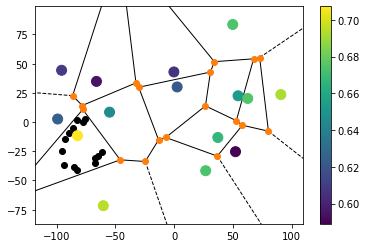

In [9]:
I = np.flip(np.argsort(sigma_m))

m_all = np.zeros((2,15))
m_save = np.empty((2,0), float)
sigma_m_save = np.empty((1,0), float)
m_all[0,:] = X
m_all[1,:] = Y

m_vor = np.zeros((2,1))

p=15
for j in range(p):
    m_vor[0], m_vor[1] = X[I[0]], Y[I[0]]
    m_curr = m_vor.copy()
    low,high=voronoi_intersect(m_curr,m_vor,m_all,0,[-100, 100])
    m_curr[0]=np.random.uniform(low = low, high = high, size=1)
    low,high=voronoi_intersect(m_curr,m_vor,m_all,1,[-100, 100])
    m_curr[1]=np.random.uniform(low = low, high = high, size=1)
    m_save = np.append( m_save, m_curr, axis=1)
    sigma_m_save = np.append(sigma_m_save, likelihood(m_curr[0], m_curr[1]))
plt.figure()
fig = voronoi_plot_2d(vor)
plt.scatter(X,Y,s=100, c=sigma_m,alpha=1,zorder=3)
plt.colorbar()
plt.scatter(m_save[0,:],m_save[1,:],c='black');

Q6) Repeat the previous step for 9 other neighbourhoods in order of decreasing likelihood (making 10 neighbourhoods in total). You are using the parameters $p=15$, $q=10$, and so you should now have 150 new models altogether. This completes one iteration of the algorithm.

<Figure size 432x288 with 0 Axes>

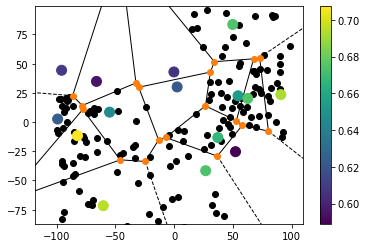

In [10]:
m_all = np.zeros((2,15))
m_save = np.empty((2,0), float)
sigma_m_save = np.empty((1,0), float)
m_all[0,:] = X
m_all[1,:] = Y

p = 15
q=10

m_vor = np.zeros((2,1))
for i in range(q):
    for j in range(p):
        m_vor[0], m_vor[1] = X[I[i]], Y[I[i]]
        m_curr = m_vor.copy()
        low,high=voronoi_intersect(m_curr,m_vor,m_all,0,[-100, 100])
        m_curr[0]=np.random.uniform(low = low, high = high, size=1)
        low,high=voronoi_intersect(m_curr,m_vor,m_all,1,[-100, 100])
        m_curr[1]=np.random.uniform(low = low, high = high, size=1)
        m_save = np.append( m_save, m_curr, axis=1)
        sigma_m_save = np.append(sigma_m_save, likelihood(m_curr[0], m_curr[1]))
plt.figure()
fig = voronoi_plot_2d(vor)
plt.scatter(X,Y,s=100, c=sigma_m,alpha=1,zorder=3)
plt.colorbar()
plt.scatter(m_save[0,:],m_save[1,:],c='black');

Q7) At the end of the first iteration, you need to add the 150 new models to m_all and the corresponding likelihood values to sigma_m. 
Then you need to generate a new index to the likelihood values in descending order. The code to do this is below. 

In [11]:
m_all = np.append(m_all, m_save,axis=1)
sigma_m = np.append(sigma_m, sigma_m_save,axis=0)
I = np.flip(np.argsort(sigma_m))

Q8) Make a scatter plot of m_all (all the models), coloured by their likelihood. Where is the model with the highest likelihood?

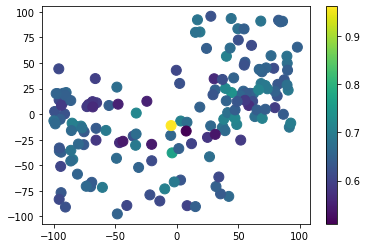

In [12]:
plt.figure()
plt.scatter(m_all[0,:],m_all[1,:],s=100, c=sigma_m,alpha=1,zorder=3)
plt.colorbar()


Q9) Now repeat the entire algorithm 5 times in total. At the end, select the model with the highest likelihood.

Most likely x and y are -7.473948, -8.746633
with likelihood 0.999140


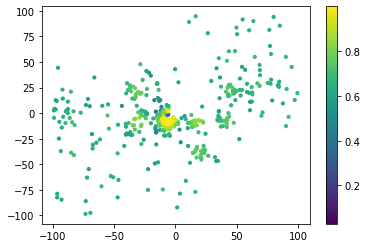

In [21]:
# set p, q
p = 15
q= 10

np.random.seed(seed=10)
X,Y = np.random.uniform(low = -100, high = 100, size=(2,p))

# initialise some key variables
m_all = np.zeros((2,p))
m_vor = np.zeros((2,1))


m_all[0,:] = X
m_all[1,:] = Y


# initial p values of the likelihood function
sigma_m = np.zeros(p)
for j in range(p):
    sigma_m[j]=likelihood(X[j],Y[j]) 
    



num_iterations = 5

for k in range(num_iterations):
    m_save = np.empty((2,0), float)
    sigma_m_save = np.empty((1,0), float)
    I = np.flip(np.argsort(sigma_m))
    for i in range(q):
        for j in range(p):
            m_vor[0], m_vor[1] = m_all[0,I[i]], m_all[1,I[i]]
            m_curr = m_vor.copy()
            low,high=voronoi_intersect(m_curr,m_vor,m_all,0,[-100, 100])
            m_curr[0]=np.random.uniform(low = low, high = high, size=1)
            low,high=voronoi_intersect(m_curr,m_vor,m_all,1,[-100, 100])
            m_curr[1]=np.random.uniform(low = low, high = high, size=1)
            m_save = np.append( m_save, m_curr, axis=1)
            sigma_m_save = np.append(sigma_m_save, likelihood(m_curr[0], m_curr[1]))
    m_all = np.append(m_all, m_save,axis=1)
    sigma_m = np.append(sigma_m, sigma_m_save,axis=0)
    
plt.figure()
plt.scatter(m_all[0,:],m_all[1,:],s=10, c=sigma_m,alpha=1,zorder=3)
plt.colorbar()

index = np.argmax( sigma_m )
print('Most likely x and y are {0:f}, {1:f}'.format(m_all[0,index],m_all[1,index]))
print('with likelihood {0:f}'.format(sigma_m[index]))

Q10) For this practical you have used values of p=15 and q=10. Try re-running with different values of p and q to see how the sampling varies. 

Most likely x and y are -7.323443, -8.816791
with likelihood 0.999150


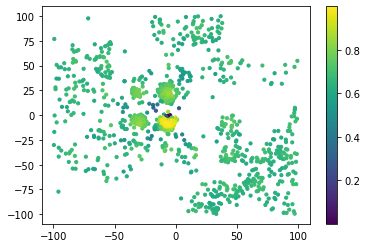

In [22]:
# set p, q
p = 35
q= 20

np.random.seed(seed=10)
X,Y = np.random.uniform(low = -100, high = 100, size=(2,p))

# initialise some key variables
m_all = np.zeros((2,p))
m_vor = np.zeros((2,1))


m_all[0,:] = X
m_all[1,:] = Y


# initial p values of the likelihood function
sigma_m = np.zeros(p)
for j in range(p):
    sigma_m[j]=likelihood(X[j],Y[j]) 
    



num_iterations = 5

for k in range(num_iterations):
    m_save = np.empty((2,0), float)
    sigma_m_save = np.empty((1,0), float)
    I = np.flip(np.argsort(sigma_m))
    for i in range(q):
        for j in range(p):
            m_vor[0], m_vor[1] = m_all[0,I[i]], m_all[1,I[i]]
            m_curr = m_vor.copy()
            low,high=voronoi_intersect(m_curr,m_vor,m_all,0,[-100, 100])
            m_curr[0]=np.random.uniform(low = low, high = high, size=1)
            low,high=voronoi_intersect(m_curr,m_vor,m_all,1,[-100, 100])
            m_curr[1]=np.random.uniform(low = low, high = high, size=1)
            m_save = np.append( m_save, m_curr, axis=1)
            sigma_m_save = np.append(sigma_m_save, likelihood(m_curr[0], m_curr[1]))
    m_all = np.append(m_all, m_save,axis=1)
    sigma_m = np.append(sigma_m, sigma_m_save,axis=0)
    
plt.figure()
plt.scatter(m_all[0,:],m_all[1,:],s=10, c=sigma_m,alpha=1,zorder=3)
plt.colorbar()

index = np.argmax( sigma_m )
print('Most likely x and y are {0:f}, {1:f}'.format(m_all[0,index],m_all[1,index]))
print('with likelihood {0:f}'.format(sigma_m[index]))